# Workshop #3
## José Luis Narváez Bolaños
## Wilmer Hernandez

*Import packages and look at the data*

In [1]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_gbq
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from pathlib import Path

In [2]:
#Define the paths of the directories
current_dir=Path('.').resolve()
#Returns to the directory’s parent folder
project_dir=Path(current_dir).parent
print(current_dir)
print(project_dir)

/home/jupyter/ESEIT_BigData/notebooks
/home/jupyter/ESEIT_BigData


In [3]:
file_data=os.path.join(project_dir,"data","raw","UCI_Credit_Card.csv")
data=pd.read_csv(file_data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

Two columns bother me because are poorly labeled.

In [5]:
data = data.rename(columns={'default.payment.next.month': 'Target', 
                        'PAY_0': 'PAY_1'})

# Clean Data

There are variables that need to be converted to categories:
- SEX: Gender
              1 = male 
              2 = female
- EDUCATION:
               1 = graduate school 
               2 = university 
               3 = high school 
               4 = others 
               5 = unknown 
               6 = unknown
- MARRIAGE: Marital status
              1 = married
              2 = single
              3 = others
- PAY_1,2,3,4,5,6: Repayment status in September 2005, August 2005, July 2005, June 2005, May 2005, April 2005 (respectivey)
              -2= no consumption
              -1= pay duly
              1 = payment delay for one month
              2 = payment delay for two months
              ... 
              8 = payment delay for eight months
              9 = payment delay for nine months and above

In [6]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [7]:
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [8]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

*As seen previously, some categories are mislabeled or undocumented. Before proceeding, it is time to fix it.*

*The 0 in MARRIAGE can be safely categorized as 'Other' (thus 3).*

*The 0 (undocumented), 5 and 6 (label unknown) in EDUCATION can also be put in a 'Other' cathegory (thus 4)*

*Thus is a good occasion to learn how to use the .loc function*

In [9]:
fil = (data.EDUCATION == 5) | (data.EDUCATION == 6) | (data.EDUCATION == 0)
data.loc[fil, 'EDUCATION'] = 4
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [10]:
data.loc[data.MARRIAGE == 0, 'MARRIAGE'] = 3
data.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

According to our documentation, the PAY_n variables indicate the number of months of delay and indicates "pay duly"with -1. Then what is -2? And what is 0? It seems to me the label has to be adjusted to 0 for pay duly.

In [11]:
fil = (data.PAY_1 == -2) | (data.PAY_1 == -1) | (data.PAY_1 == 0)
data.loc[fil, 'PAY_1'] = 0
fil = (data.PAY_2 == -2) | (data.PAY_2 == -1) | (data.PAY_2 == 0)
data.loc[fil, 'PAY_2'] = 0
fil = (data.PAY_3 == -2) | (data.PAY_3 == -1) | (data.PAY_3 == 0)
data.loc[fil, 'PAY_3'] = 0
fil = (data.PAY_4 == -2) | (data.PAY_4 == -1) | (data.PAY_4 == 0)
data.loc[fil, 'PAY_4'] = 0
fil = (data.PAY_5 == -2) | (data.PAY_5 == -1) | (data.PAY_5 == 0)
data.loc[fil, 'PAY_5'] = 0
fil = (data.PAY_6 == -2) | (data.PAY_6 == -1) | (data.PAY_6 == 0)
data.loc[fil, 'PAY_6'] = 0
late = data[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

## Create the target and the features variables

In [12]:
X=data.drop(["ID","Target"],axis=1) #features variables
Y=data["Target"] #Variable Target
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

# Split and Train Test

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [14]:
print('Total train data:', X_train.shape)
print('Total test data:', X_test.shape)

Total train data: (21000, 23)
Total test data: (9000, 23)


In [15]:
print('Total train label:', Y_train.shape)
print('Total test label:', Y_test.shape)

Total train label: (21000,)
Total test label: (9000,)


# Correlation between features

<AxesSubplot:>

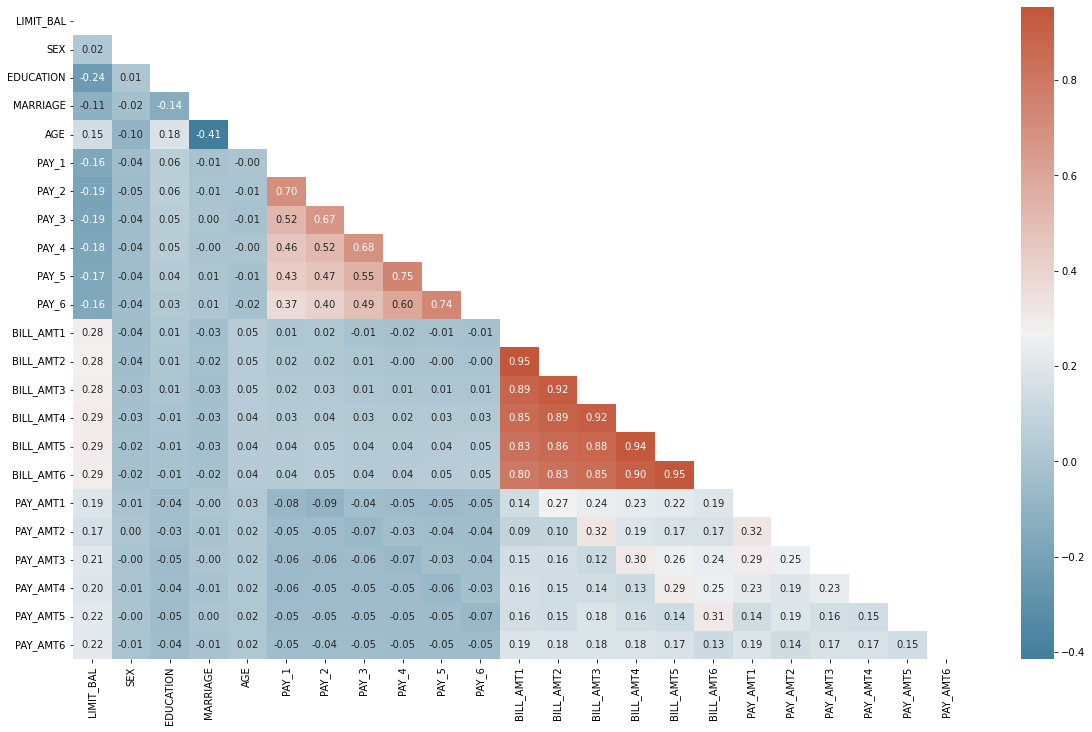

In [16]:
plt.figure(figsize=(20,12))
corr_matrix=X_train.corr()
mask=np.triu(np.ones_like(corr_matrix,dtype=bool))
cmap=sns.diverging_palette(230,20, as_cmap=True)

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f"
)

# Eliminate variables with high correlation

In [17]:
corr_matrix=corr_matrix.abs()

mask=np.triu(np.ones_like(corr_matrix, dtype=bool))

tri_df=corr_matrix.mask(mask)

to_drop=[x for x in tri_df.columns if any(tri_df[x]>0.8)]

X_train=X_train.drop(to_drop,axis=1)
X_test=X_test.drop(to_drop,axis=1)
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
28465,240000.0,2,1,1,40,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27622,50000.0,2,1,2,23,0,0,0,0,0,0,660.0,2548.0,2321.0,4800.0,9810.0,660.0,2980.0
28376,50000.0,2,2,1,36,2,2,2,2,0,0,35126.0,0.0,4700.0,0.0,2004.0,3500.0,0.0
10917,200000.0,2,3,1,54,6,5,4,3,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27234,240000.0,1,1,1,35,0,0,0,0,0,0,22659.0,2017.0,21817.0,1120.0,13434.0,22772.0,22820.0


In [18]:
X_train.shape

(21000, 18)

In [19]:
X_test.shape

(9000, 18)

# Data Scaling

In [20]:
#Si los datos varian se aplica Standard, si los datos son fijos se aplica MinMax
from sklearn.preprocessing import StandardScaler

sc= StandardScaler().fit(X_train)

X_train_scaled=sc.transform(X_train)
X_test_scaled=sc.transform(X_test)

print('X_train shape:', X_train_scaled.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test_scaled.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (21000, 18)
Y_train shape: (21000,)
X_test shape: (9000, 18)
Y_test shape: (9000,)


# Label Encoder AKA One-Hot Encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder().fit(Y_train)
Y_train_enc=le.transform(Y_train)
Y_test_enc=le.transform(Y_test)

print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_train_enc, return_counts=True))

(array([0, 1]), array([16324,  4676]))
(array([0, 1]), array([16324,  4676]))


# PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
#Explicar la reducción de dimensionalidad de la mayor varianza del 95% de las variables
pca=PCA(0.95).fit(X_train_scaled)
X_train_pca=pca.transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)

In [24]:
pca.explained_variance_ratio_

array([0.2195189 , 0.13234999, 0.08454385, 0.06011543, 0.05619255,
       0.05465628, 0.05146839, 0.04853438, 0.04655049, 0.0417922 ,
       0.03780183, 0.03589261, 0.03236802, 0.02869575, 0.02674444])

# Feature Importance for PCA

In [25]:
rows=X_train.columns

columns=[]
for i in range(15):
    columns.append('PC_{}'.format(i+1))
    
feature_importance=pd.DataFrame(
    pca.components_.T,
    index=rows,
    columns=columns
)
feature_importance

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
LIMIT_BAL,-0.182573,0.319384,-0.072918,-0.486025,-0.079820,0.143167,0.056924,0.060600,-0.018100,0.078091,-0.201683,0.274587,-0.331943,-0.587634,-0.089786
SEX,-0.034000,-0.030706,0.077885,0.075372,-0.967900,0.048630,0.070725,0.023460,-0.013649,0.012813,-0.015081,-0.020574,-0.135914,0.147886,0.007035
EDUCATION,0.059160,-0.083036,-0.374651,0.586913,-0.059097,-0.364931,-0.164938,-0.315439,-0.026726,0.107989,-0.136373,0.190226,-0.154534,-0.381372,-0.065650
MARRIAGE,0.008014,-0.055422,0.633685,0.115952,0.170311,-0.153077,-0.066316,-0.099235,-0.016465,0.076847,-0.143608,0.155304,-0.646734,0.214381,-0.000923
AGE,-0.017613,0.079327,-0.658720,-0.094046,0.095281,0.107393,0.003870,0.059234,0.026532,-0.001365,-0.001069,-0.034405,-0.522105,0.500539,0.037520
PAY_1,0.356501,0.074560,-0.021279,-0.044024,0.000263,-0.285746,0.396978,0.205300,-0.020120,0.008500,-0.005475,0.064950,-0.009512,0.032095,-0.506433
PAY_2,0.388706,0.084849,-0.015332,-0.034983,0.000202,-0.282297,0.366555,0.173360,-0.022367,-0.002952,0.022482,0.018719,-0.017075,-0.000331,-0.015458
PAY_3,0.406622,0.104506,0.006526,-0.015633,-0.013208,-0.063765,0.139506,0.052554,0.003882,-0.002935,-0.063859,-0.132765,-0.069816,-0.123739,0.588020
PAY_4,0.416688,0.115280,0.006824,-0.017515,-0.026440,0.160349,-0.148936,-0.080570,0.045421,-0.043215,-0.015776,-0.030731,-0.066437,-0.104729,0.356269
PAY_5,0.406299,0.120115,0.025643,-0.018828,-0.031881,0.268731,-0.282222,-0.138964,0.044940,0.022993,0.041415,0.021811,-0.018250,-0.021385,-0.143404


In [26]:
total_var=pca.explained_variance_ratio_.sum()*100
total_var

95.72250956500731

In [27]:
variance_ratios=pd.DataFrame(
    pca.explained_variance_ratio_.reshape(1,15),
    columns=columns,
    index=["Explained Variance Ratio"]
)
variance_ratios

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
Explained Variance Ratio,0.219519,0.13235,0.084544,0.060115,0.056193,0.054656,0.051468,0.048534,0.04655,0.041792,0.037802,0.035893,0.032368,0.028696,0.026744


Text(113.09375, 0.5, 'Features')

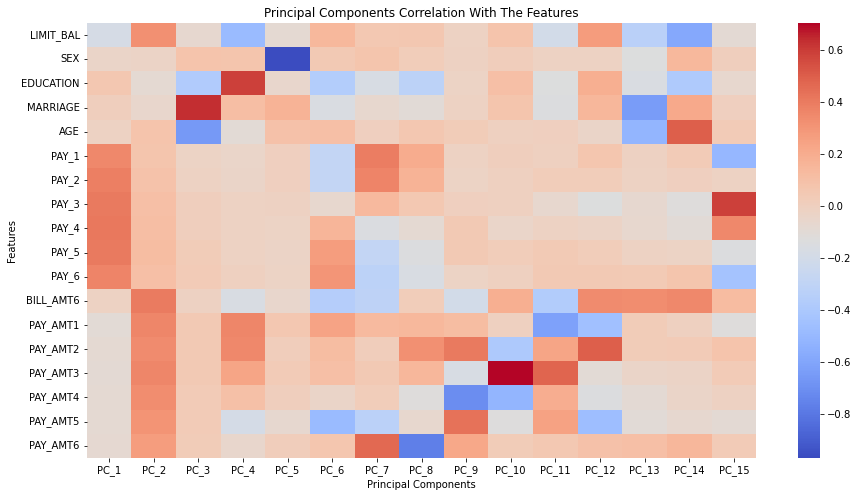

In [28]:
plt.figure(figsize=(15,8))
sns.heatmap(feature_importance,cmap="coolwarm")
plt.title("Principal Components Correlation With The Features")
plt.xlabel("Principal Components")
plt.ylabel("Features")

# Train Model

In [29]:
from sklearn.svm import SVC
svc=SVC(random_state=42)
svc.fit(X_train_pca, Y_train_enc)

SVC(random_state=42)

In [30]:
y_pred=svc.predict(X_test_pca)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
svc.predict(X_test_pca[0].reshape(1,-1))

array([0])

In [32]:
from sklearn.metrics import classification_report
print(
    classification_report(Y_test_enc,y_pred)
)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.65      0.33      0.44      1960

    accuracy                           0.81      9000
   macro avg       0.74      0.64      0.66      9000
weighted avg       0.79      0.81      0.79      9000



# Cross-Validation

In [35]:
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=5).split(X_train_pca,Y_train_enc)

scores=list()
for k, (train,test) in enumerate(kfold):
    svc.fit(X_train_pca[train],Y_train_enc[train])
    score=svc.score(X_train_pca[test],Y_train_enc[test])
    scores.append(score)
    #bincount, conteo de clases
    print('Fold: {}, Class dist.: {}, Acc: {}'.format(k+1, np.bincount(Y_train_enc[train]), score) )
print('CV accuracy: {} +/- {}'.format(
    np.round(np.mean(scores), 2),
    np.round(np.std(scores), 2)
))

Fold: 1, Class dist.: [13060  3740], Acc: 0.819047619047619
Fold: 2, Class dist.: [13059  3741], Acc: 0.8152380952380952
Fold: 3, Class dist.: [13059  3741], Acc: 0.8138095238095238
Fold: 4, Class dist.: [13059  3741], Acc: 0.8066666666666666
Fold: 5, Class dist.: [13059  3741], Acc: 0.8102380952380952
CV accuracy: 0.81 +/- 0.0


In [36]:
from sklearn.model_selection import learning_curve

train_sizes,train_scores, test_scores=learning_curve(
    estimator=svc,
    X=X_train_pca,
    y=Y_train_enc,
    train_sizes=np.linspace(0.1,1.0,10),
    cv=10,
    n_jobs=-1
)

In [37]:
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)

In [38]:
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

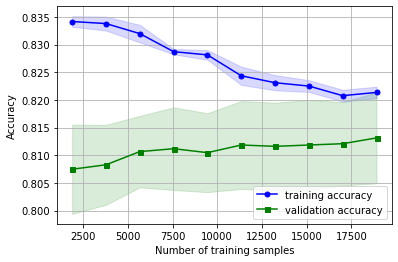

In [39]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Hyperparameter adjustment

In [ ]:
from sklearn.model_selection import GridSearchCV

values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4] 
red_parametros = [
    {'C': values, 'kernel': ['linear'] },
    {'C': values, 'kernel': ['rbf'], 'gamma':values}
]


gs = GridSearchCV(
    estimator  = svc,
    param_grid = red_parametros,
    scoring    = 'accuracy',
    cv         = 10,
    n_jobs     = -1
)

In [ ]:
gs = gs.fit(X_train_scaled, Y_train_enc)
print(gs.best_score_)
print(gs.best_params_)

In [40]:
fpr, tpr, _ = roc_curve(Y_test_enc, y_pred)
auc = round(roc_auc_score(Y_test_enc, y_pred), 4)

# Train Model II

The ideal is to try more models to see which is the most suitable, this time we will implentation the code "Random Forest"

Accuracy: 0.8131111111111111

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.63      0.34      0.44      1960

    accuracy                           0.81      9000
   macro avg       0.74      0.64      0.66      9000
weighted avg       0.79      0.81      0.79      9000


Average 5-Fold CV Score: 0.8208 , Standard deviation: 0.0097


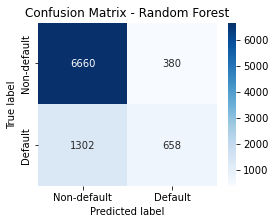

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
Ran = RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train_pca, Y_train_enc)
y_pred1 = Ran.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_pred1,Y_test_enc))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, Y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(Y_test_enc, y_pred1))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(Y_test_enc,Ran.predict(X_test_pca))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

In [42]:
fpr1, tpr1, _ = roc_curve(Y_test_enc, y_pred1)
auc1 = round(roc_auc_score(Y_test_enc, y_pred1), 4)

# Train Model III

The next method to implement is "DecisionTreeClassifier"

Accuracy: 0.8083333333333333

              precision    recall  f1-score   support

           0       0.84      0.94      0.88      7040
           1       0.60      0.35      0.44      1960

    accuracy                           0.81      9000
   macro avg       0.72      0.64      0.66      9000
weighted avg       0.79      0.81      0.79      9000


Average 5-Fold CV Score: 0.8109 , Standard deviation: 0.01


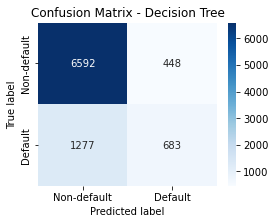

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 7, 
                                     max_features= 9, min_samples_leaf= 2, 
                                     random_state=0)
Tree.fit(X_train_pca, Y_train_enc)
y_pred2 = Tree.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_pred2,Y_test_enc))

## 5-fold cross-validation 
cv_scores =cross_val_score(Tree, X, Y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(Y_test_enc, y_pred2))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)), 
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(Y_test_enc,Tree.predict(X_test_pca))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

In [44]:
fpr3, tpr3, _ = roc_curve(Y_test_enc, y_pred2)
auc3 = round(roc_auc_score(Y_test_enc, y_pred2), 4)

# Train Model IV

Another method is "KNeighborsClassifier"

In [45]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train_pca,Y_train_enc)
pred_y = model.predict(X_test_pca)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test_enc,pred_y))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7040
           1       0.53      0.34      0.42      1960

    accuracy                           0.79      9000
   macro avg       0.68      0.63      0.65      9000
weighted avg       0.77      0.79      0.77      9000



In [46]:
fpr4, tpr4, _ = roc_curve(Y_test_enc, pred_y)
auc4 = round(roc_auc_score(Y_test_enc, pred_y), 4)

# Train Model V

The method that has the best metrics is "RidgeClssifier"

In [47]:
from sklearn.linear_model import RidgeClassifier

In [48]:
df_X = data[['SEX','MARRIAGE','AGE','BILL_AMT1','EDUCATION','PAY_1']]
df_y = data.Target

model5 = RidgeClassifier()
model5.fit(X_train_pca, Y_train_enc)

y_pred4 = model5.predict(X_test_pca)
y_train_pred = model5.predict(X_train_pca)

print(classification_report(y_pred4, Y_test_enc))
print(confusion_matrix(y_pred4, Y_test_enc))
print('\nTest Accuracy Score for model5: ', accuracy_score(y_pred4,Y_test_enc))
print('\nTrain Accuracy Score for model5: ', accuracy_score(y_train_pred,Y_train_enc))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      8191
           1       0.27      0.67      0.39       809

    accuracy                           0.81      9000
   macro avg       0.62      0.75      0.64      9000
weighted avg       0.90      0.81      0.84      9000

[[6769 1422]
 [ 271  538]]

Test Accuracy Score for model5:  0.8118888888888889

Train Accuracy Score for model5:  0.8123809523809524


In [49]:
fpr5, tpr5, _ = roc_curve(Y_test_enc, y_pred4)
auc5 = round(roc_auc_score(Y_test_enc, y_pred4), 4)

# Train Model VI

Finally the one with the second best metrics was "Logistic Regression"

In [50]:
from sklearn.linear_model import LogisticRegression
model4 = LogisticRegression()
model4.fit(X_train_pca, Y_train_enc)

y_pred5 = model4.predict(X_test_pca)
y_train_pred1= model4.predict(X_train_pca)

print(classification_report(y_pred5, Y_test_enc))
print(confusion_matrix(y_pred5, Y_test_enc))
print('\nTest Accuracy Score for model4: ', accuracy_score(y_pred5,Y_test_enc))
print('\nTrain Accuracy Score for model4: ', accuracy_score(y_train_pred1,Y_train_enc))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      8138
           1       0.29      0.66      0.40       862

    accuracy                           0.81      9000
   macro avg       0.62      0.74      0.64      9000
weighted avg       0.89      0.81      0.84      9000

[[6743 1395]
 [ 297  565]]

Test Accuracy Score for model4:  0.812

Train Accuracy Score for model4:  0.813


In [51]:
fpr6, tpr6, _ = roc_curve(Y_test_enc, y_pred5)
auc6 = round(roc_auc_score(Y_test_enc, y_pred5), 4)

# ROC Curve

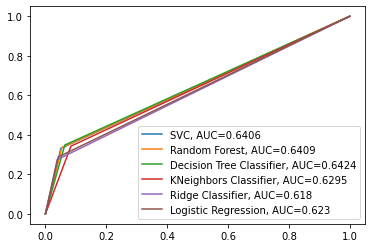

In [52]:
plt.plot(fpr,tpr,label="SVC, AUC="+str(auc))
plt.plot(fpr1,tpr1,label="Random Forest, AUC="+str(auc1))
plt.plot(fpr3,tpr3,label="Decision Tree Classifier, AUC="+str(auc3))
plt.plot(fpr4,tpr4,label="KNeighbors Classifier, AUC="+str(auc4))
plt.plot(fpr5,tpr5,label="Ridge Classifier, AUC="+str(auc5))
plt.plot(fpr6,tpr6,label="Logistic Regression, AUC="+str(auc6))
plt.legend()

# Select Analysis 
If only ML methods are focused omitting some correlated variables, the metrics will be distributed as follows.

In [53]:
X1 = data[['SEX','MARRIAGE','AGE','BILL_AMT6','EDUCATION','PAY_1']]
Y1 = data.Target

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X1,Y1,test_size=0.3,random_state=42)

In [55]:
from sklearn.preprocessing import StandardScaler

sc= StandardScaler().fit(X_train)

X_train_scaled=sc.transform(X_train)
X_test_scaled=sc.transform(X_test)

print('X_train shape:', X_train_scaled.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test_scaled.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (21000, 6)
Y_train shape: (21000,)
X_test shape: (9000, 6)
Y_test shape: (9000,)


In [56]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder().fit(Y_train)
Y_train_enc=le.transform(Y_train)
Y_test_enc=le.transform(Y_test)

print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_train_enc, return_counts=True))

(array([0, 1]), array([16324,  4676]))
(array([0, 1]), array([16324,  4676]))


In [57]:
pca=PCA(0.90).fit(X_train_scaled)
X_train_pca=pca.transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)

In [58]:
pca.explained_variance_ratio_

array([0.25340007, 0.17753797, 0.16631452, 0.16424469, 0.1444972 ])

In [59]:
from sklearn.svm import SVC
svc=SVC(random_state=42)
svc.fit(X_train_pca, Y_train_enc)

SVC(random_state=42)

In [60]:
y_pred=svc.predict(X_test_pca)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
svc.predict(X_test_pca[0].reshape(1,-1))

array([0])

In [62]:
from sklearn.metrics import classification_report
print(
    classification_report(Y_test_enc,y_pred)
)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7040
           1       0.69      0.31      0.43      1960

    accuracy                           0.82      9000
   macro avg       0.76      0.64      0.66      9000
weighted avg       0.80      0.82      0.79      9000



Accuracy: 0.8192222222222222

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7040
           1       0.68      0.32      0.43      1960

    accuracy                           0.82      9000
   macro avg       0.76      0.64      0.66      9000
weighted avg       0.80      0.82      0.79      9000


Average 5-Fold CV Score: 0.8208 , Standard deviation: 0.0097


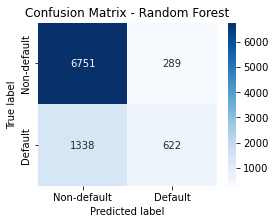

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
Ran = RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 150, 
                                     random_state=0)
Ran.fit(X_train_pca, Y_train_enc)
y_pred1 = Ran.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_pred1,Y_test_enc))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X, Y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(Y_test_enc, y_pred1))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(Y_test_enc,Ran.predict(X_test_pca))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

Accuracy: 0.814

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      7040
           1       0.65      0.31      0.42      1960

    accuracy                           0.81      9000
   macro avg       0.74      0.63      0.65      9000
weighted avg       0.79      0.81      0.79      9000


Average 5-Fold CV Score: 0.8161 , Standard deviation: 0.0069


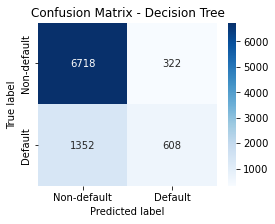

In [64]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 7, 
                                     max_features= 5, min_samples_leaf= 2, 
                                     random_state=0)
Tree.fit(X_train_pca, Y_train_enc)
y_pred2 = Tree.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_pred2,Y_test_enc))

## 5-fold cross-validation 
cv_scores =cross_val_score(Tree, X, Y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(Y_test_enc, y_pred2))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)), 
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(Y_test_enc,Tree.predict(X_test_pca))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

In [65]:

from sklearn.linear_model import RidgeClassifier
model5 = RidgeClassifier()
model5.fit(X_train_pca, Y_train_enc)

y_pred4 = model5.predict(X_test_pca)
y_train_pred = model5.predict(X_train_pca)

print(classification_report(y_pred4, Y_test_enc))
print(confusion_matrix(y_pred4, Y_test_enc))
print('\nTest Accuracy Score for model5: ', accuracy_score(y_pred4,Y_test_enc))
print('\nTrain Accuracy Score for model5: ', accuracy_score(y_train_pred,Y_train_enc))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      8090
           1       0.32      0.69      0.44       910

    accuracy                           0.82      9000
   macro avg       0.64      0.76      0.66      9000
weighted avg       0.89      0.82      0.85      9000

[[6755 1335]
 [ 285  625]]

Test Accuracy Score for model5:  0.82

Train Accuracy Score for model5:  0.8194285714285714


In [66]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train_pca,Y_train_enc)
pred_y = model.predict(X_test_pca)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test_enc,pred_y))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7040
           1       0.53      0.33      0.41      1960

    accuracy                           0.79      9000
   macro avg       0.68      0.62      0.64      9000
weighted avg       0.77      0.79      0.77      9000



This allows you to change the metrics

# Other method

To reset the ML models, install the imblearn package which provides tools when dealing with classification with imbalanced classes.

In [67]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [68]:
import imblearn as imb

In [69]:
from imblearn.over_sampling import SMOTE

In [70]:
smote = SMOTE(sampling_strategy='minority')

In [71]:
X_sm , y_sm = smote.fit_resample(X_train,Y_train)

In [72]:
y_sm.value_counts()

1    16324
0    16324
Name: Target, dtype: int64

The imblearn package is applied to the above methods, thus improving metrics.

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [74]:
sc =StandardScaler()
X_scaled = sc.fit_transform(X_sm)

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_sm,test_size=.25,random_state=1,stratify=y_sm)

In [76]:
from sklearn.svm import SVC
model = SVC(random_state=42)
model.fit(X_train,y_train)
pred_y = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       0.68      0.75      0.72      4081
           1       0.73      0.65      0.69      4081

    accuracy                           0.70      8162
   macro avg       0.70      0.70      0.70      8162
weighted avg       0.70      0.70      0.70      8162



In [77]:
fp, tp, _ = roc_curve(y_test, pred_y)
aucx = round(roc_auc_score(y_test, pred_y), 4)

In [78]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
pred_y1 = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,pred_y1))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      4081
           1       0.73      0.63      0.68      4081

    accuracy                           0.70      8162
   macro avg       0.70      0.70      0.70      8162
weighted avg       0.70      0.70      0.70      8162



In [79]:
fp1, tp1, _ = roc_curve(y_test, pred_y1)
aucx1 = round(roc_auc_score(y_test, pred_y1), 4)

In [80]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train,y_train)
pred_y2 = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,pred_y2))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4081
           1       0.69      0.69      0.69      4081

    accuracy                           0.69      8162
   macro avg       0.69      0.69      0.69      8162
weighted avg       0.69      0.69      0.69      8162



In [81]:
fp2, tp2, _ = roc_curve(y_test, pred_y2)
aucx2 = round(roc_auc_score(y_test, pred_y2), 4)

In [82]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
pred = model.predict(X_test)
print("Classification Report \n")
print(classification_report(y_test,pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test,pred))

Classification Report 

              precision    recall  f1-score   support

           0       0.72      0.69      0.71      4081
           1       0.71      0.73      0.72      4081

    accuracy                           0.71      8162
   macro avg       0.71      0.71      0.71      8162
weighted avg       0.71      0.71      0.71      8162

Confusion Matrix

[[2834 1247]
 [1095 2986]]


In [83]:
fp3, tp3, _ = roc_curve(y_test, pred)
aucx3 = round(roc_auc_score(y_test, pred), 4)

In [84]:
model = RidgeClassifier()
model.fit(X_train,y_train)
pred1 = model.predict(X_test)
print("Classification Report \n")
print(classification_report(y_test,pred1))
print("Confusion Matrix\n")
print(confusion_matrix(y_test,pred1))

Classification Report 

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      4081
           1       0.73      0.63      0.68      4081

    accuracy                           0.70      8162
   macro avg       0.70      0.70      0.70      8162
weighted avg       0.70      0.70      0.70      8162

Confusion Matrix

[[3128  953]
 [1509 2572]]


In [85]:
fp4, tp4, _ = roc_curve(y_test, pred1)
aucx4 = round(roc_auc_score(y_test, pred1), 4)

Accuracy: 0.7039941190884587

              precision    recall  f1-score   support

           0       0.69      0.75      0.72      4081
           1       0.73      0.65      0.69      4081

    accuracy                           0.70      8162
   macro avg       0.71      0.70      0.70      8162
weighted avg       0.71      0.70      0.70      8162


Average 5-Fold CV Score: 0.8119 , Standard deviation: 0.0074


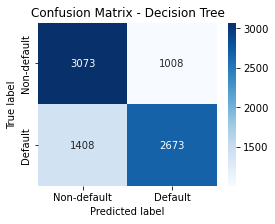

In [86]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 7, 
                                     max_features= 6, min_samples_leaf= 2, 
                                     random_state=0)
Tree.fit(X_train, y_train)
pred2 = Tree.predict(X_test)
print('Accuracy:', accuracy_score(pred2,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Tree, X, Y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, pred2))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)), 
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Tree.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Decision Tree");

In [87]:
fp5, tp5, _ = roc_curve(y_test, pred2)
aucx5 = round(roc_auc_score(y_test, pred2), 4)

# ROC Curve

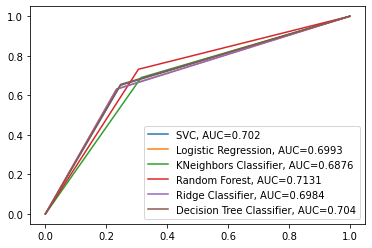

In [88]:
plt.plot(fp,tp,label="SVC, AUC="+str(aucx))
plt.plot(fp1,tp1,label="Logistic Regression, AUC="+str(aucx1))
plt.plot(fp2,tp2,label="KNeighbors Classifier, AUC="+str(aucx2))
plt.plot(fp3,tp3,label="Random Forest, AUC="+str(aucx3))
plt.plot(fp4,tp4,label="Ridge Classifier, AUC="+str(aucx4))
plt.plot(fp5,tp5,label="Decision Tree Classifier, AUC="+str(aucx5))
plt.legend()

**In conclusion, the best method to apply is RandomForest(), followed by KNeightborClassifer, which, handles the best metrics for the dataset**